### **<font color='teal'> 1. Sourcing and Loading the Data </font>**

##### **<font color='teal'> 1.1. Importing Libraries </font>**

In [77]:
#!pip install tensorflow

In [78]:
!pip install jupyterthemes

In [79]:
# Importing and checking the version of Tensor Flow.
import tensorflow as tf
tf.version.VERSION

'2.14.0'

In [80]:
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import pickle
from tensorflow.python.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from scipy import ndimage
import cv2  # OpenCV for flipping and scaling

#from jupyterthemes import jtplot
#jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False) 

##### **<font color='teal'> 1.2. Loading the data </font>**

In [81]:
# Reading and checking the CSV file
df=pd.read_csv("../data/emotion.csv")
df

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
3,2,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
4,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
...,...,...
24563,3,0 39 81 80 104 97 51 64 68 46 41 67 53 68 70 5...
24564,0,181 177 176 156 178 144 136 132 122 107 131 16...
24565,3,178 174 172 173 181 188 191 194 196 199 200 20...
24566,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


### **<font color='teal'> 2. Exploring the Data </font>**

##### **<font color='teal'> 2.1. Renaming Column Name </font>**

In [82]:
# 'pixels' column has space in the csv file so we are removing that space .
df = df.rename(columns={' pixels': 'pixels'})

In [83]:
df['pixels'][2]

'24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 19 43 52 13 26 40 59 65 12 20 63 99 98 98 111 75 62 41 73 118 140 192 186 187 188 190 190 187 182 176 173 172 173 25 34 29 35 29 26 20 23 19 31 22 21 20 31 26 17 34 75 37 18 38 80 85 25 38 26 34 97 94 76 86 95 70 39 98 129 185 188 188 189 190 190 188 182 176 173 172 173 26 29 25 35 25 30 20 21 16 28 34 26 15 17 19 22 29 62 64 47 45 76 76 78 65 82 12 14 56 56 72 74 66 65 86 129 172 190 187 189 190 190 187 182 177 172 172 174 26 33 32 31 25 33 26 21 16 16 37 27 14 15 12 17 31 38 40 58 73 59 35 82 68 72 43 22 33 52 51 66 71 57 71 121 160 191 188 189 190 190 187 184 178 173 173 174 29 40 29 29 32 32 28 26 19 13 23 34 17 18 14 15 26 25 21 40 82 44 29 34 36 32 36 59 55 38 46 64 71 62 60 107 137 191 189 190 190 190 188 184 178 175 173 175 33 39 25 33 37 33 25 30 20 18 18 23 20 22 20 17 33 20 18 25 37 31 22 29 28 24 29 38 67 38 35 75 68 66 58 89 110 179 191 189 189 190 187 184 179 175 173 174 32 41 32 31 39 33 26 34 27 23 28 30 21 24 29 22 26 23 21

In [84]:
df.shape

(24568, 2)

##### **<font color='teal'> 2.2. Converting pixel values in string format to array format </font>**

In [85]:
# function to convert pixel values in string format to array format
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [86]:
df['pixels'] = df['pixels'].apply(lambda x: string2array(x))

In [87]:
type(df['pixels'][2])

numpy.ndarray

In [88]:
df['pixels'][2].shape

(48, 48, 1)

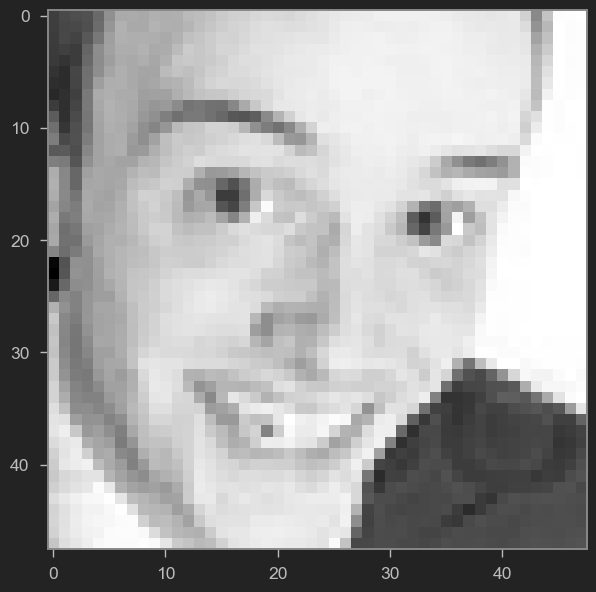

In [89]:
# Visualizing the first image within the dataframe ,just to make sure that the reshaping process does not cause distortion.
plt.imshow(df['pixels'][100],cmap='gray')

##### **<font color='teal'> 2.3. Checking for Null Values </font>**

In [90]:
df.isna().sum()

emotion    0
pixels     0
dtype: int64

In [91]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad'}

##### **<font color='teal'> 2.4. Checking No of Samples in each Emotion </font>**

In [92]:
a= df['emotion'].value_counts().rename('Count')
b= (df['emotion'].value_counts(normalize = True)*100).rename('Distribution')
temp=pd.concat([a,b], axis = 1)
temp.index = ['Happy','Fear','Angry','Sad','Disgust']
temp

,Count,Distribution
Happy,8989,36.588245
Fear,6077,24.735428
Angry,4953,20.160371
Sad,4002,16.289482
Disgust,547,2.226473


<Figure size 3000x1000 with 0 Axes>

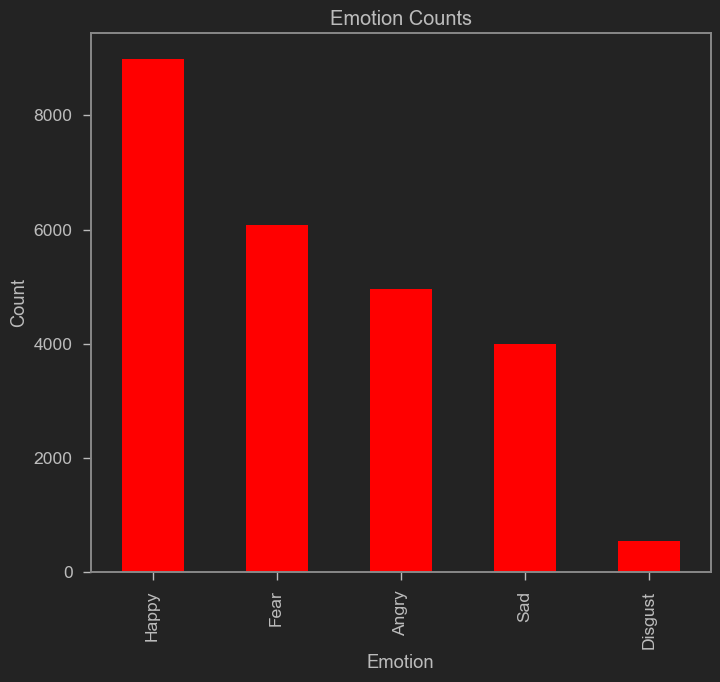

In [93]:
plt.figure(figsize=(30,10))
temp.plot(y='Count', kind='bar', legend=False,color='red')  # Plot the 'Count' column as a bar chart

# Set the title and labels
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Display the plot
plt.show()

**<font color='blue'> We can clearly see that the data is Imbalanced </font>**

**<font color='blue'> We will then apply data augmentation Techniques to balance the data  </font>**

##### **<font color='teal'> 2.5. Checking a Sample in each Emotion </font>**

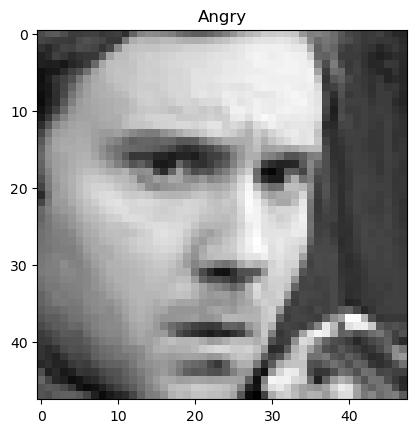

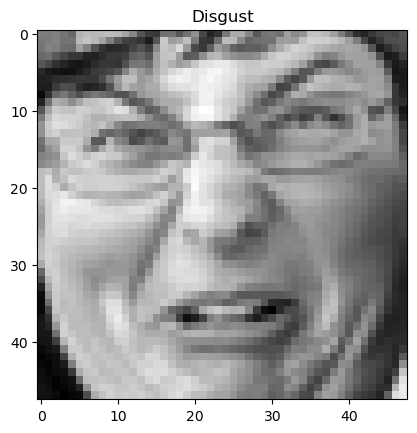

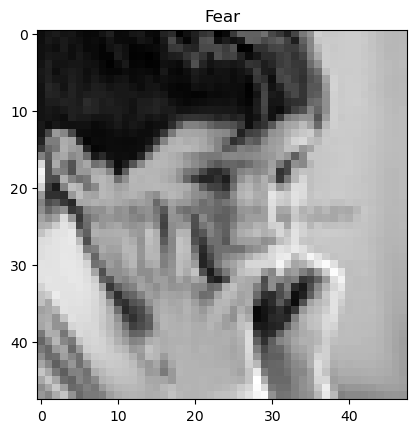

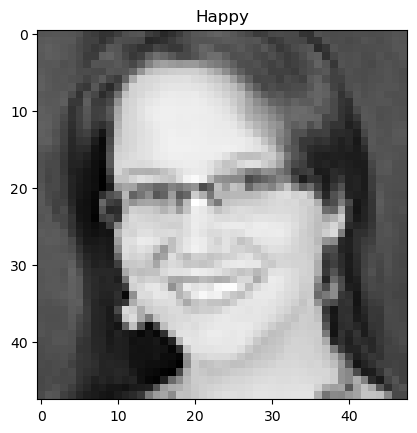

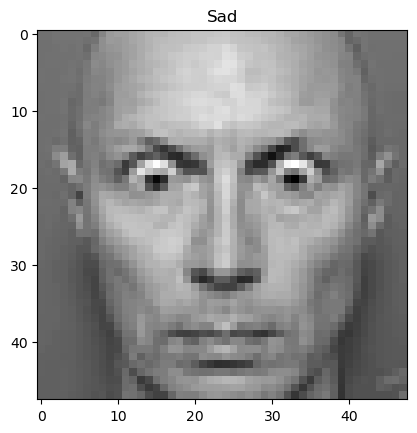

In [32]:
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad'}
emotions = [0,1,2,3,4]

for i in emotions:
  data = df[df['emotion'] == i][:1]
  img = data['pixels'].item()
  img = img.reshape(48,48)
  plt.figure()
  plt.title(emotions_labels[i])
  plt.imshow(img, cmap= 'gray')

### **<font color='teal'> 3. Image Augmentation </font>**

**<font color='blue'>Image augmentation is a technique used in machine learning and computer vision to artificially increase the size of a training dataset by applying various transformations to the original data. These transformations include operations like rotating, flipping, scaling, cropping, adjusting brightness or contrast, and more. Data augmentation is commonly used when training machine learning models, particularly deep learning models for image classification, object detection, and other tasks. By applying these transformations to the existing data, the model becomes more robust and generalizes better to real-world scenarios, as it has learned to recognize objects or patterns from various perspectives and conditions.</font>**

![Alt text](image.png)

##### **<font color='teal'> 3.1. Creating Image Augmentation Function </font>**

In [19]:
def image_augmentation(augmentation_num,Images,emotion_label):
    # Define the number of augmented images you want per input image
    num_augmentations = augmentation_num

    # Create an array to store augmented images
    augmented_images = []

    # Loop through each input image
    for image in Images:
        # Ensure that each image has a consistent shape (48, 48)
        image = image.reshape(48, 48,1)

        for _ in range(num_augmentations):
            # Rotate the image by a random angle between -20 and 20 degrees
            rotated_image = ndimage.rotate(image, np.random.uniform(-20, 20), reshape=False)

            # Flip the image horizontally (left to right) with a 50% probability
            if np.random.choice([True, False]):
                rotated_image = np.fliplr(rotated_image)
            
            # Append the augmented image to the list
            augmented_images.append(rotated_image)

    
    # Create a DataFrame for the augmented data
    augmented_df = pd.DataFrame({'emotion': emotion_label, 'pixels': augmented_images})
    return augmented_df
            



**<font color='blue'> Data Augmentation for Disgust Images </font>**

In [20]:
disgust_images=df[df['emotion']==1]
augmented_disgust=image_augmentation(15,disgust_images['pixels'],1)
df = pd.concat([df, augmented_disgust], ignore_index=True)


**<font color='blue'> Data Augmentation for Sad Images </font>**

In [21]:
sad_images=df[df['emotion']==4]
augmented_sad=image_augmentation(1,sad_images['pixels'],4)
df = pd.concat([df, augmented_sad], ignore_index=True)

**<font color='blue'> Data Augmentation for Angry Images </font>**

In [22]:
angry_images=df[df['emotion']==0]
augmented_angry=image_augmentation(1,angry_images['pixels'],0)
df = pd.concat([df, augmented_angry], ignore_index=True)

In [23]:
df.tail()

,emotion,pixels
41723,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [210.3774..."
41724,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
41725,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
41726,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
41727,0,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [24]:
emotions_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad'}

a = df['emotion'].value_counts().rename('Count')
b = (df['emotion'].value_counts(normalize=True) * 100).rename('Distribution')

temp = pd.concat([a, b], axis=1)
temp.index = [emotions_labels[i] for i in temp.index]
temp

,Count,Distribution
Angry,9906,23.739456
Happy,8989,21.541890
Disgust,8752,20.973926
Sad,8004,19.181365
Fear,6077,14.563363


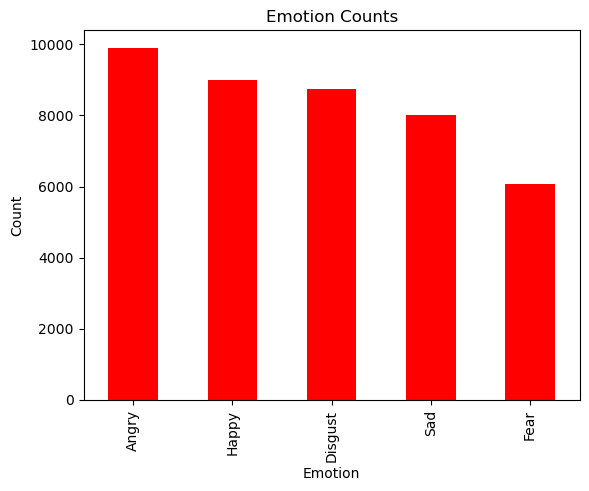

In [25]:
temp.plot(y='Count', kind='bar', legend=False,color='red')  # Plot the 'Count' column as a bar chart

# Set the title and labels
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Count')

# Display the plot
plt.show()

**<font color='blue'> Now, the dataset is well-balanced, ensuring that each class has a nearly equal number of samples. </font>**

In [31]:


X = df['pixels']
y = pd.get_dummies(df['emotion'])

X = np.stack(X, axis = 0)
X = X.reshape(df.shape[0], 48, 48, 1)

print(X.shape, y.shape)

(41728, 48, 48, 1) (41728, 5)
